In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.fft import fft, ifft, fftfreq
from numba import jit

In [3]:
q1 = 1*1.6*(10**(-19))
q2 = 24*1.6*(10**(-19))
m1 = 135*1.66*(10**(-27))
m2 = 9000*1.66*(10**(-27))
omega_rf = 2*np.pi*5.2*1e6#5.2*1e6
a_1 = -0.003513682524049352
a_1_ax = -0.0035125*0.9999692029230125#0.99996
q_1 = 0.31801801801801804*0.998#*0.999
Q = q2/q1
kappa = 0.248
z0 = 3/4*2.7*1e-3
r0 = 3/4*3.5*1e-3
epsilon = 8.85*1e-12
V_end = -a_1*m1*(z0**2)*(omega_rf**2)/(4*q1*kappa)
V_rf = q_1/(2*q1)*(m1*r0**2*omega_rf**2)
V_end_ax = -a_1_ax*m1*(z0**2)*(omega_rf**2)/(4*q1*kappa)
omega_1z = np.sqrt(np.abs(a_1)/2)*omega_rf
omega_1zax = np.sqrt(np.abs(a_1_ax)/2)*omega_rf
hbar = 1 *1e-34
print(np.sqrt(2*q1*kappa*V_end/(m1*z0**2))/(2*np.pi)*1e-3)
print(omega_1z/(2*np.pi)*1e-3)
z1eq = np.cbrt(q1*q2*1/(4*np.pi*epsilon*m1*omega_1z**2*(1+1/Q)**2))
z2eq = -z1eq/Q
z1eq_ax = np.cbrt(q1*q2*1/(4*np.pi*epsilon*m1*omega_1zax**2*(1+1/Q)**2))
z2eq_ax = -z1eq_ax/Q
print(z1eq,z2eq)

@jit
def CoulombForce(charge_1,charge_2,pos1,pos2):
  #Calculates coulomb force of particle with charge charge_2 in position pos2
  # enacted on particle of charge charge_1 in position pos1.
  F = charge_1*charge_2/(4*np.pi*epsilon*np.linalg.norm(pos1-pos2)**3)*(pos1-pos2)
  return F
@jit
def voltage_force_axial(charge,voltage,pos):
  #Calculates the axial harmonic force on ion of some charge given an endcap
  # voltage and at some position pos.
  return -2*charge*kappa*voltage/(z0**2)*pos

@jit
def radial_force_static(charge,voltage,pos):
  return kappa*charge*voltage/(z0**2)*pos
@jit
def radial_force_RF(voltage,charge,pos,t):
  return -voltage*charge*pos/(r0**2)*np.cos(omega_rf*t)


def potential_energy(charge1,charge2,V_DC,V_DC_a,V_RF,pos1,pos2):
  # Returns the potential energy offset from equilibrium of a set of two ions, in eV. Assumes the RF potential is maximal at t = 0.
  
  #### VARIABLES
  # q_1 - charge of particle 1
  # q_2 - charge of particle _2
  # V_DC - DC voltage
  # V_RF - RF Voltage
  # pos 1 - position of particle 1 in vector format [z1,y1]
  # pos2 - position of particle 2 in vector format [z2,y2]

  z1 = pos1[0]
  z2 = pos2[0]
  y1 = pos1[1]
  y2  = pos2[1]

  z1eq = np.cbrt(charge1*charge2*1/(4*np.pi*epsilon*m1*omega_1z**2*(1+1/Q)**2))
  z2eq = -z1eq/Q
  U0 = 6.241509*1e18*kappa/(z0**2)*V_DC_a*(charge1*z1eq**2+charge2*z2eq**2)+6.241509*1e18*charge1*charge2/(4*np.pi*epsilon*np.abs(z1-z2))

  U_ax = 6.241509*1e18*kappa/(z0**2)*V_DC_a*(charge1*z1**2+charge2*z2**2)     #Potential energy from the axial oscillator
  U_rad = -6.241509*1e18*kappa*V_end/(2*z0**2)*(charge1*y1**2+charge2*y2**2)+6.241509*1e18*V_RF/(2*r0**2)*(charge1*y1**2+charge2*y2**2)     #Radial oscillator + RF energy
  U_C = 6.241509*1e18*charge1*charge2/(4*epsilon*np.pi*np.linalg.norm(pos1-pos2))
  return (U_ax+U_rad+U_C)-U0

def initialization_scan_y(delta_range,vector,charge1,charge2,V_DC,V_DC_a,V_RF):
  # Scans initalization energies along the y-direction.
  
  #### VARIABLES
  # delta_range - linspace of "push lengths to search over"
  # vector - vector to push along
  Energies = [potential_energy(charge1,charge2,V_DC,V_DC_a,V_RF,np.array([z1eq,delta*vector[0]/np.sqrt(m1*1.66*1e27)]),np.array([z2eq,delta*vector[1]/np.sqrt(m2*1.66*1e27)])) for delta in delta_range]
  return Energies

@jit
def full_eq_motion(t,Y):
    z1 = Y[0]
    z2 = Y[1]
    y1 = Y[2]
    y2 = Y[3]
    dz1dt = Y[4]
    dz2dt = Y[5]
    dy1dt = Y[6]
    dy2dt = Y[7]
    r1 = np.array([z1,y1])
    r2 = np.array([z2,y2])
    dz1dtdt = voltage_force_axial(q1,V_end_ax,z1)/m1+CoulombForce(q1,q2,r1,r2)[0]/m1
    dz2dtdt = voltage_force_axial(q2,V_end_ax,z2)/m2+CoulombForce(q1,q2,r2,r1)[0]/m2
    dy1dtdt = radial_force_static(q1,V_end,y1)/m1+CoulombForce(q1,q2,r1,r2)[1]/m1+radial_force_RF(V_rf,q1,y1,t)/m1
    dy2dtdt = radial_force_static(q2,V_end,y2)/m2+CoulombForce(q1,q2,r2,r1)[1]/m2+radial_force_RF(V_rf,q2,y2,t)/m2
    return [dz1dt,dz2dt,dy1dt,dy2dt,dz1dtdt,dz2dtdt,dy1dtdt,dy2dtdt]

print(CoulombForce(q1,q2,np.array([0,z1eq]),np.array([0,z2eq])))
print(voltage_force_axial(q1,V_end,z1eq))
print(V_rf)
print(V_end)
vec = np.array([0.09172445083122983, 0.995784427032131])
vec2 = np.array([0.995784427032131,-0.09172445083122983])
vecr1 = np.array([0.9997236805385642, 0.023506649493850323])
vecr = np.array([0.023506649493854552, -0.9997236805385643])
# print(potential_energy(q1,q2,V_end,V_rf,np.array([z1eq,1e-17*vecr[0]/np.sqrt(m1)]),np.array([z2eq,1e-17*vecr[1]/np.sqrt(m2)])))


217.95638950291695
217.95638950291692
2.2966769494805023e-05 -9.569487289502092e-07


C:\Users\Emil\AppData\Local\Temp\ipykernel_12404\3388828082.py:29: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def CoulombForce(charge_1,charge_2,pos1,pos2):
C:\Users\Emil\AppData\Local\Temp\ipykernel_12404\3388828082.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def voltage_force_axial(charge,voltage,pos):
C:\Users\Emil\AppData\Local\Temp\ipykernel_124

[0.00000000e+00 9.65252011e-18]
-9.652520109961087e-18
1634.9300851648259
21.716468354208022


In [286]:
z_init = 1e-6
v0 = 0
def dzdt(t,y):
  z = y[0]
  v = y[1]
  dzdt = v
  dvdt = voltage_force_axial(q1,V_end,z)/m1
  return[dzdt,dvdt]
from scipy.integrate import solve_ivp
solution1 = solve_ivp(dzdt,[0,0.5*1e-4],[z_init,v0],max_step = 1e-8)
print(solution1)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 30032
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.32680717e-13, 5.85948789e-12, ...,
       4.99859186e-05, 4.99959186e-05, 5.00000000e-05])
 t_events: None
        y: array([[ 1.00000000e-06,  1.00000000e-06,  1.00000000e-06, ...,
         7.89192626e-07,  7.97528844e-07,  8.00888283e-07],
       [ 0.00000000e+00, -9.99000999e-07, -1.09890110e-05, ...,
         8.41048270e-01,  8.26169178e-01,  8.20051766e-01]])
 y_events: None


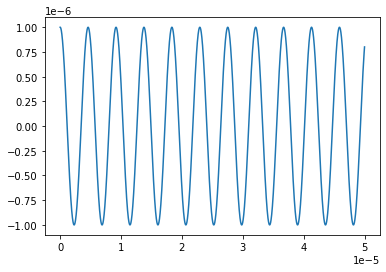

In [227]:
plt.plot(solution1.t,solution1.y[0])

In [228]:
from scipy.integrate import solve_ivp
z_init = 1e-6
v0 = 0
def dzdt2(t,y):
    z=y[0]
    v = y[1]
    dzdt = v
    dvdt = voltage_force_axial(q2,V_end,z)/m2
    return [dzdt,dvdt]
solution2 = solve_ivp(dzdt2,[0,5*1e-5],[z_init,v0],max_step =1e-7)

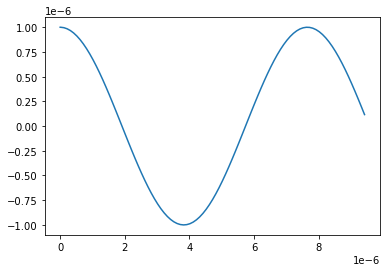

In [229]:
fig,ax = plt.subplots()
ax.plot(solution2.t[0:100],solution2.y[0][0:100])

In [7]:
vec = np.array([0.09172445083122983, 0.995784427032131])
from scipy.integrate import solve_ivp
def eq_of_motion(t,y):
    z1=y[0]
    z2=y[1]
    v1=y[2]
    v2=y[3]
    dz1dt=v1
    dz2dt=v2
    dv1dt = voltage_force_axial(q1,V_end,z1)/m1+CoulombForce(q1,q2,z1,z2)/m1
    dv2dt = voltage_force_axial(q2,V_end,z2)/m2+CoulombForce(q1,q2,z2,z1)/m2
    return[dz1dt,dz2dt,dv1dt,dv2dt]
eq_motion_solution = solve_ivp(eq_of_motion,[0,5*1e-5],[z1eq+1e-18*vec[0]/np.sqrt(m1),z2eq+1e-18*vec[1]/np.sqrt(m2),0,0],max_step=2*1e-7)

C:\Users\Emil\AppData\Local\Temp\ipykernel_13600\2674283725.py:23: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "CoulombForce" failed type inference due to: No implementation of function Function(<function norm at 0x0000020BF11D8820>) found for signature:
 
 >>> norm(float64)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba\np\linalg.py: Line 2427.
    With argument(s): '(float64)':
   Rejected as the implementation raised a specific error:
     TypingError: np.linalg.norm() only supported for array types 
  raised from c:\Users\Emil\anaconda3\lib\site-packages\numba\np\linalg.py:966

During: resolving callee type: Function(<function norm at 0x0000020BF11D8820>)
During: typing of call at C:\Users\Emil\AppData\Local\Temp\ipykernel_13600\2674283725.py (27)


File "..\AppData\Local\Temp\ipykernel_13600\2674283725.py", line 27:
<source missing, REPL/exec in us

Text(0.5, 0, 'Time / µs')

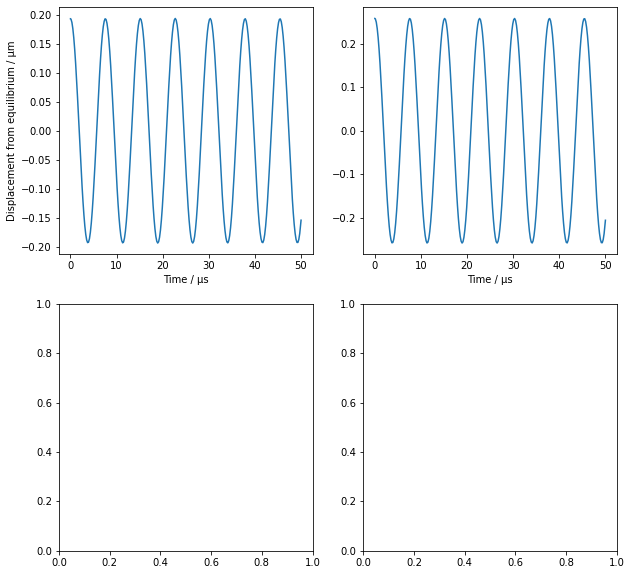

In [231]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(eq_motion_solution.t*1e6,np.array(eq_motion_solution.y[0])*1e6-z1eq*1e6)
ax[0,1].plot(eq_motion_solution.t*1e6,np.array(eq_motion_solution.y[1])*1e6-z2eq*1e6)
ax[0,0].set_ylabel('Displacement from equilibrium / µm')
ax[0,0].set_xlabel('Time / µs')
ax[0,1].set_xlabel('Time / µs')

In [8]:
vec = np.array([0.09172445083122983, 0.995784427032131])
vec2 = np.array([0.995784427032131,-0.09172445083122983])
print(np.dot(vec,vec2))
print(np.dot(np.array([1e-6*vec[0],1e-6*vec[1]]),vec2))
print(np.linalg.norm(np.array(z1eq,z2eq)))
vectors = np.zeros((np.size(eq_motion_solution.t),2))
for n,z1 in enumerate(eq_motion_solution.y[0]):
    vectors[n,0] = (z1-z1eq)*np.sqrt(137)
    vectors[n,1] = (eq_motion_solution.y[1][n]-z2eq)*np.sqrt(9000)
dotprods = [np.dot(v,vec) for v in vectors]
dotprods2 = [np.dot(v,vec2) for v in vectors]
print(vec[0]*np.sqrt(5*hbar/(m1*2*np.pi*137*1e3)))
print(vec[1]*np.sqrt(5*hbar/(m2*2*np.pi*137*1e3)))
TestDispl = np.array([vec[0]*np.sqrt(5*hbar/(m1*2*np.pi*137*1e3)),vec[1]*np.sqrt(5*hbar/(m2*2*np.pi*137*1e3))])
vec2weighted = np.array([vec2[0]/m1,vec2[1]/m2])

0.0
0.0
2.2966769494805023e-05
4.669807479059748e-09
6.2090451197363035e-09


In [233]:
vec = np.array([0.09172445083122983, 0.995784427032131])
vec2 = np.array([0.995784427032131,-0.09172445083122983])

2.4545558676062484e-05
-2.4544758502315086e-05


(-3.0000000000000004e-05, 3.0000000000000004e-05)

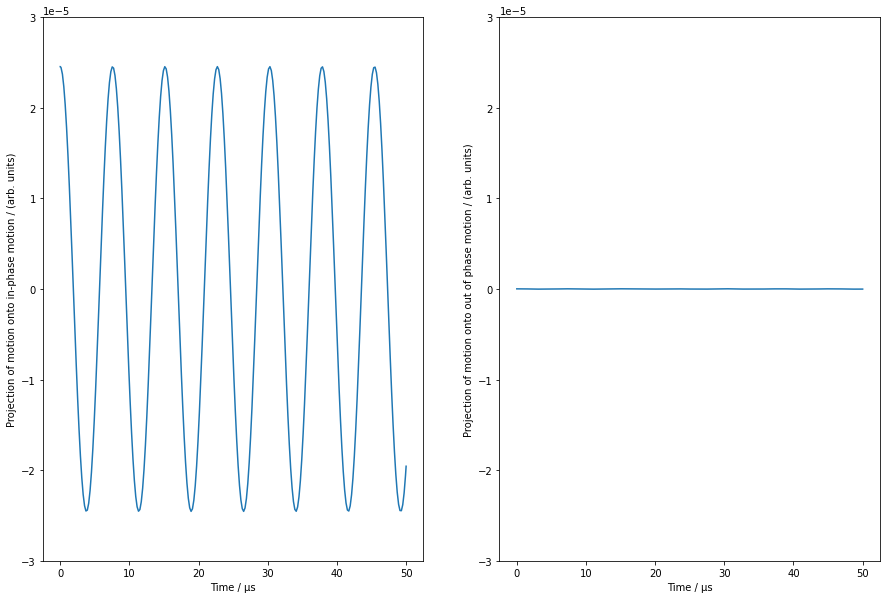

In [234]:
fig,ax = plt.subplots(1,2,figsize =(15,10))
ax[0].plot(eq_motion_solution.t[0:500]*1e6,np.array(dotprods))
ax[1].plot(eq_motion_solution.t[0:500]*1e6,np.array(dotprods2))
print(np.max(dotprods))
print(np.min(dotprods))
ax[0].set_ylabel('Projection of motion onto in-phase motion / (arb. units)')
ax[1].set_ylabel('Projection of motion onto out of phase motion / (arb. units)')
ax[0].set_xlabel('Time / µs')
ax[1].set_xlabel('Time / µs')
ax[0].set_ylim(-3*1e-5,3*1e-5)
ax[1].set_ylim(-3*1e-5,3*1e-5)

Can we do the same for the other mode?

In [236]:
eq_motion_solution_2 = solve_ivp(eq_of_motion,[0,5*1e-5],[z1eq+1e-18*vec2[0]/np.sqrt(m1),z2eq+1e-18*vec2[1]/np.sqrt(m2),0,0],max_step=1e-7)

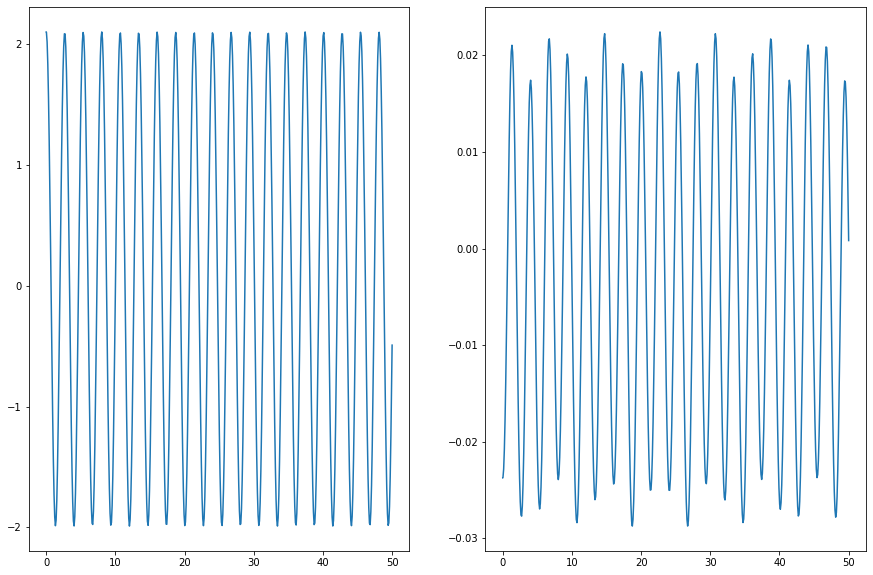

In [240]:
fig,ax = plt.subplots(1,2,figsize = (15,10))
ax[0].plot(eq_motion_solution_2.t*1e6,(eq_motion_solution_2.y[0]-z1eq)*1e6)
ax[1].plot(eq_motion_solution_2.t*1e6,(eq_motion_solution_2.y[1]-z2eq)*1e6)

(-3.0000000000000004e-05, 3.0000000000000004e-05)

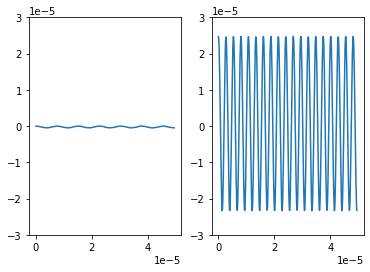

In [242]:
vectors2 = np.zeros((500,2))
for n,z1 in enumerate(eq_motion_solution_2.y[0][0:500]):
    vectors2[n,0] = (z1-z1eq)*np.sqrt(137)
    vectors2[n,1] = (eq_motion_solution_2.y[1][n]-z2eq)*np.sqrt(9000)
fig,ax = plt.subplots(1,2)
s2dotprods = [np.dot(v,vec) for v in vectors2]
s2dotprods2 = [np.dot(v,vec2) for v in vectors2]
ax[0].plot(eq_motion_solution_2.t[0:500],s2dotprods)
ax[1].plot(eq_motion_solution_2.t[0:500],s2dotprods2)
ax[0].set_ylim(-3*1e-5,3*1e-5)
ax[1].set_ylim(-3*1e-5,3*1e-5)

In [6]:


eq_motion_solution_F = solve_ivp(full_eq_motion,[0,5*1e-5],[z1eq+1e-18*vec[0]/np.sqrt(m1),z2eq+1e-18*vec[1]/np.sqrt(m2),0,0,0,0,0,0],max_step=2*1e-7)


C:\Users\Emil\AppData\Local\Temp\ipykernel_13600\2527667325.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def full_eq_motion(t,Y):


NameError: name 'vec' is not defined

In [9]:
# fig,ax = plt.subplots(2,2)
# ax[0,0].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[0]-z1eq)
# ax[0,1].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[1]-z2eq)
# ax[1,0].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[2])
# ax[1,1].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[3])
vecr = np.array([0.023506649493854552, -0.9997236805385643])

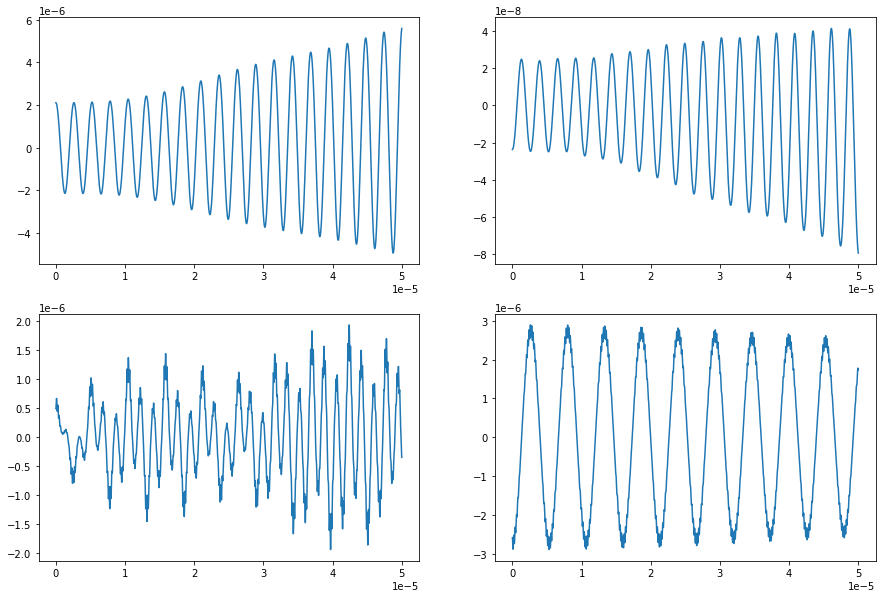

In [245]:
eq_motion_solution_F = solve_ivp(full_eq_motion,[0,5*1e-5],[z1eq+1e-18*vec2[0]/np.sqrt(m1),z2eq+1e-18*vec2[1]/np.sqrt(m2),1e-17*vecr[0]/np.sqrt(m1),1e-17*vecr[1]/np.sqrt(m2),0,0,0,0],max_step=5*1e-9)
fig,ax = plt.subplots(2,2,figsize = (15,10))
ax[0,0].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[0]-z1eq)
ax[0,1].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[1]-z2eq)
ax[1,0].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[2])
ax[1,1].plot(eq_motion_solution_F.t,eq_motion_solution_F.y[3])
# print((1e-18/np.sqrt(m1))**3)
# print(np.abs(np.min(eq_motion_solution_F.y[0]-eq_motion_solution_F.y[1])))
# print(eq_motion_solution_F.y[3])
# print([z1eq,z2eq,1e-17*vecr[0]/np.sqrt(m1),1e-17*vecr[1]/np.sqrt(m2)])


In [10]:
vecr1 = np.array([0.9997236805385642, 0.023506649493850323])

vec_ax = np.zeros((np.size(eq_motion_solution_F.y[0]),2))
print(vec_ax)
for j,z1 in enumerate(eq_motion_solution_F.y[0]):
    vec_ax[j,0] = (z1-z1eq)*np.sqrt(137)
    vec_ax[j,1] = (eq_motion_solution_F.y[1][j]-z2eq)*np.sqrt(9000)
vec_rad = np.zeros((np.size(eq_motion_solution_F.y[2]),2))
for j ,y1 in enumerate(eq_motion_solution_F.y[2]):
    vec_rad[j,0] = y1*np.sqrt(137)
    vec_rad[j,1] = eq_motion_solution_F.y[3][j]*np.sqrt(9000)
dprods_ax1 = [np.dot(v,vec) for v in vec_ax]
dprods_ax2 = [np.dot(v,vec2) for v in vec_ax]
dprods_rad2 = [np.dot(v,vecr) for v in vec_rad]
dprods_rad1 = [np.dot(v,vecr1) for v in vec_rad]

NameError: name 'eq_motion_solution_F' is not defined

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

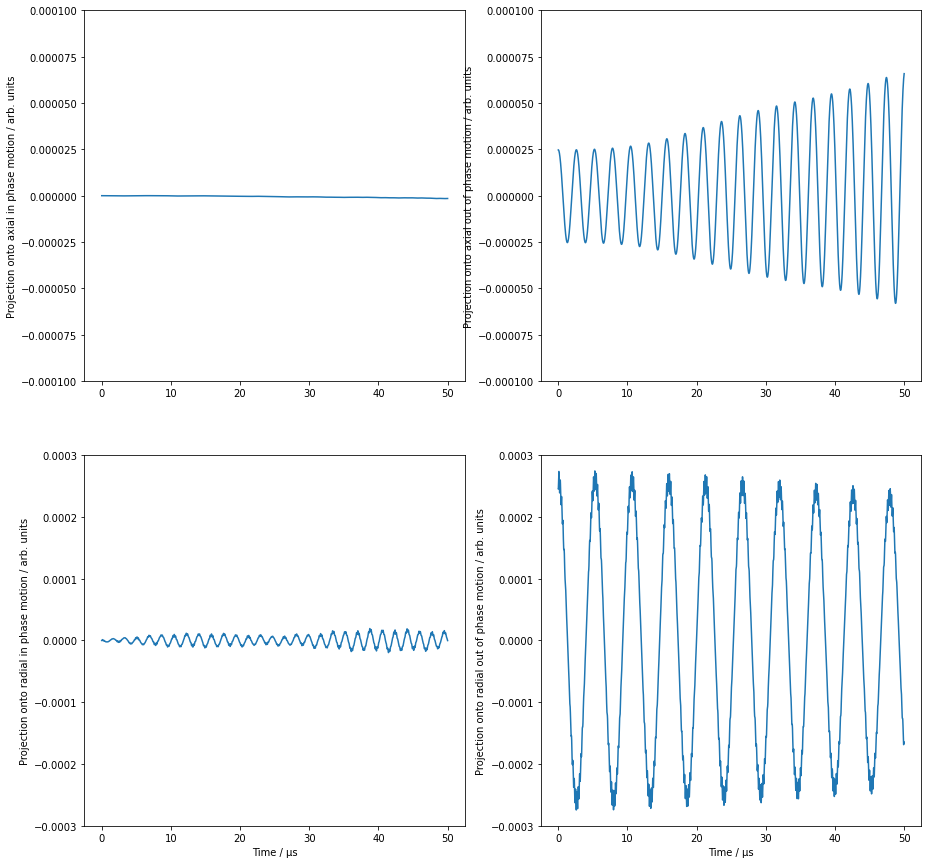

In [247]:
fig,ax = plt.subplots(2,2,figsize = (15,15))
ax[0,0].plot(eq_motion_solution_F.t*1e6,dprods_ax1)
ax[0,1].plot(eq_motion_solution_F.t*1e6,dprods_ax2)
ax[0,0].set_ylim(-1e-4,1e-4)
ax[0,1].set_ylim(-1e-4,1e-4)
ax[1,1].plot(eq_motion_solution_F.t*1e6,dprods_rad2)
ax[1,0].plot(eq_motion_solution_F.t*1e6,dprods_rad1)
ax[1,0].set_ylim(-0.3*1e-3,0.3*1e-3)
ax[1,1].set_ylim(-0.3*1e-3,0.3*1e-3)
ax[1,0].set_xlabel('Time / µs')
ax[1,1].set_xlabel('Time / µs')
ax[0,0].set_ylabel('Projection onto axial in phase motion / arb. units')
ax[0,1].set_ylabel('Projection onto axial out of phase motion / arb. units')
ax[1,0].set_ylabel('Projection onto radial in phase motion / arb. units')
ax[1,1].set_ylabel('Projection onto radial out of phase motion / arb. units')
plt.tight_layout

In [40]:
#normalize the data
fit_ys =dprods_rad2/(np.max(np.abs(dprods_rad2)))



def cos_fit(x,w):
    return np.cos(w*x)
popt,pcov = curve_fit(cos_fit,eq_motion_solution_F.t*1e5,fit_ys,p0 = [2*np.pi*1.8],maxfev = 100000000)
print(dprods_rad2[0])
print(popt/(2*np.pi))
w = popt
fig,ax = plt.subplots()
ax.plot(eq_motion_solution_F.t*1e5,fit_ys)
ax.plot(eq_motion_solution_F.t*1e5,cos_fit(eq_motion_solution_F.t*1e5,w))

C:\Users\Emil\AppData\Local\Temp/ipykernel_19268/2834654519.py:2: RuntimeWarning: invalid value encountered in true_divide
  fit_ys =dprods_rad2/(np.max(np.abs(dprods_rad2)))


ValueError: array must not contain infs or NaNs

In [298]:
def single_particle_radial_checker(t,Y):
    z = Y[0]
    dzdt = Y[1]
    y = Y[2]
    dydt = Y[3]
    dzdtdt = voltage_force_axial(q1,V_end,z)/m1
    dydtdt = radial_force_RF(V_rf,q1,y,t)/m1 + radial_force_static(q1,V_end,y)/m1
    return [dzdt,dzdtdt,dydt,dydtdt]
single_particle_sol = solve_ivp(single_particle_radial_checker,[0,1*1e-5],[1e-18*vec2[0]/np.sqrt(m1),0,1e-16*vecr[0]/np.sqrt(m1),0],max_step = 5*1e-10)

4.965577944278191e-06
2.1035091323496132e-06
563.990567481153


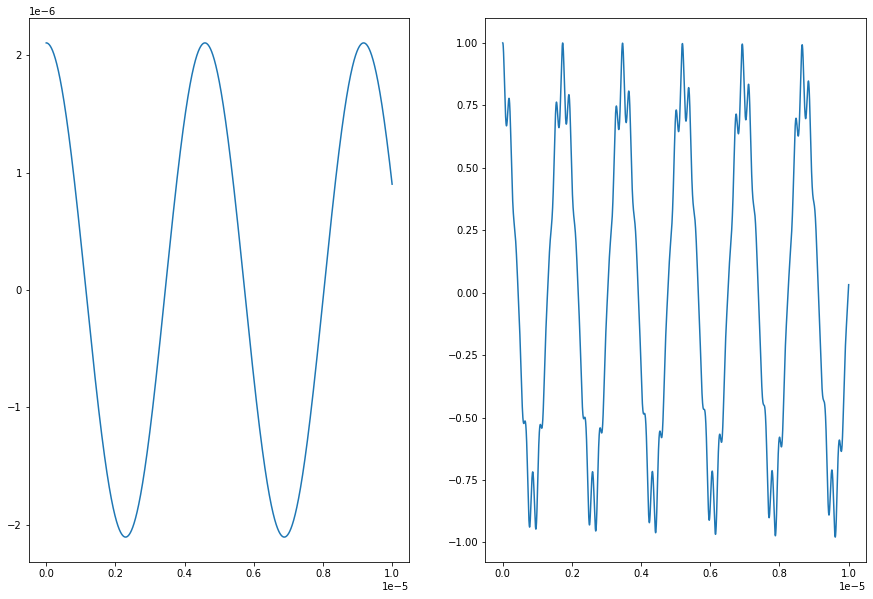

In [299]:
fig,ax = plt.subplots(1,2,figsize = (15,10))
ax[0].plot(single_particle_sol.t,single_particle_sol.y[0])
ax[1].plot(single_particle_sol.t,single_particle_sol.y[2]/(np.max(single_particle_sol.y[2])))
print(1e-16*vecr[0]/np.sqrt(m1))
print(1e-18*vec2[0]/np.sqrt(m1))
print(omega_rf/2*np.sqrt(q_1**2/(2)+a_1)/(2*np.pi)*1e-3)

[5.75637605]
[1.02065112]


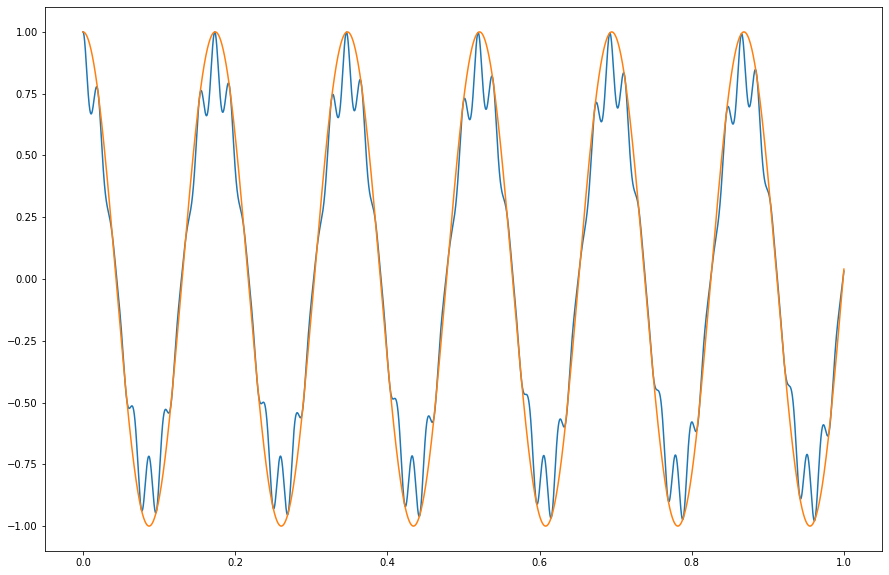

In [300]:
fig,ax = plt.subplots(figsize = (15,10))
ax.plot(single_particle_sol.t*1e5,single_particle_sol.y[2]/(np.max(single_particle_sol.y[2])))
popt2,pcov2 = curve_fit(cos_fit,single_particle_sol.t*1e5,single_particle_sol.y[2]/(np.max(single_particle_sol.y[2])),p0 = 2*np.pi*6)
print(popt2/(2*np.pi))
ax.plot(single_particle_sol.t*1e5,cos_fit(single_particle_sol.t*1e5,popt2))
print(popt2*100/(2*np.pi)/(omega_rf/2*np.sqrt(q_1**2/(2)+a_1)/(2*np.pi)*1e-3))

Try to initialzie only radial motion.... not sure if this works at all due to geometry.


In [296]:
sol_y = solve_ivp(full_eq_motion,[0,5*1e-4],[z1eq,z2eq,1e-17*vecr[0]/np.sqrt(m1),1e-17*vecr[1]/np.sqrt(m2),0,0,0,0],max_step=5*1e-9)

2.2966769494805023e-05


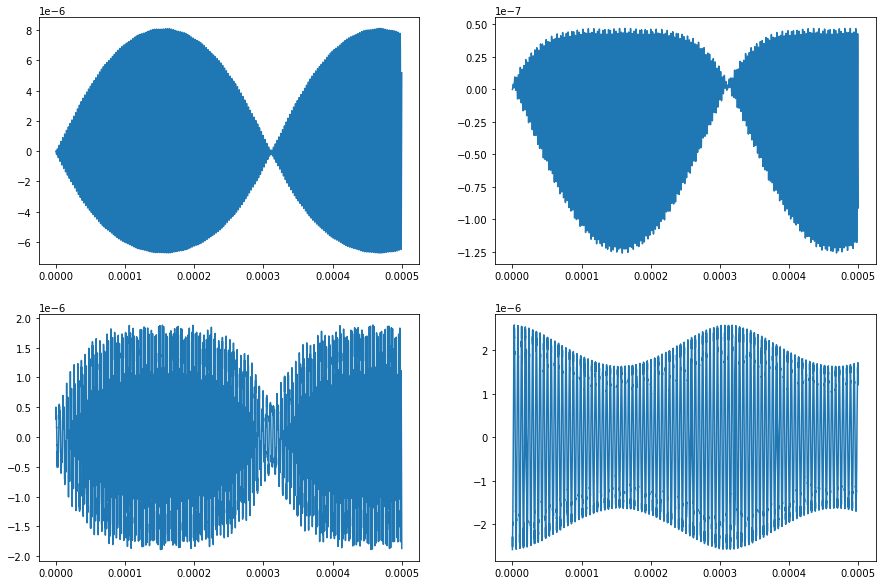

In [297]:
fig,ax = plt.subplots(2,2,figsize = (15,10))
ax[0,0].plot(sol_y.t,sol_y.y[0]-z1eq)
ax[0,1].plot(sol_y.t,sol_y.y[1]-z2eq)
print(z1eq)
ax[1,0].plot(sol_y.t,sol_y.y[2])
ax[1,1].plot(sol_y.t,sol_y.y[3])



In [6]:
E_test1 = initialization_scan_y(np.linspace(1*1e-7,1*1e-6,100000),vecr,q1,q2,V_end,V_end_ax,V_rf)

(-1.0000000000000001e-11, 1.0000000000000001e-11)

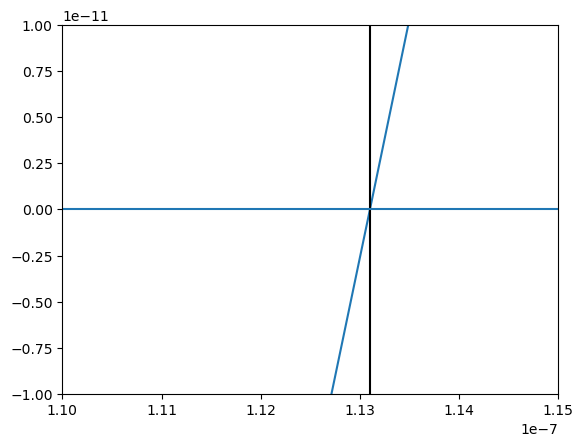

In [9]:
# print(vecr)
plt.plot(np.linspace(1*1e-7,1*1e-6,100000)[0:10000],np.array(E_test1)[0:10000]-6.242*1e18*2*hbar*2*np.pi*186000)
#print(np.array(E_test1[0:100])-6.242*1e18*5*hbar*2*np.pi*186000)
plt.axvline(1.131*1e-7,color = 'k')
plt.axhline(0)
plt.xlim([1.1*1e-7,1.15*1e-7])
plt.ylim(-0.01*1e-9,0.01*1e-9)

In [30]:
print(potential_energy(q1,q2,V_end,V_rf,np.array([z1eq,1*vecr[0]/np.sqrt(m1*1.66*1e27)]),np.array([z2eq,1*vecr[1]/np.sqrt(m2*1.66*1e27)])))

114127.01086774029


Now know the range to search for delta-wise.

In [78]:
def zero_func(delta):
    return potential_energy(q1,q2,V_end,V_rf,np.array([z1eq,delta*vecr[0]/np.sqrt(m1*1.66*1e27)]),np.array([z2eq,delta*vecr[1]/np.sqrt(m2*1.66*1e27)]))-6.242*1e18*2*hbar*2*np.pi*186000

# zero = fsolve(zero_func,0.0008)
print(zero_func(1.8*1e-7))
# print(zero)
# print(zero_func(zero))
# plt.plot(np.linspace(1e-7,1*1e-6,100000)[0:10000],np.array(E_test1)[0:10000]-6.242*1e18*5*hbar*2*np.pi*186000)
# plt.axhline(0,ls = '--', color = 'k')
# plt.axvline(zero,ls = '--',color = 'k')
# plt.xlabel(r'$\delta$')
# plt.ylabel(r'Configuration energy difference from $5\hbar\omega$ / eV')

2.2364085663117573e-09


In [10]:
zero = 1.131*1e-7
sol_y2 = solve_ivp(full_eq_motion,[0,2],[z1eq_ax,z2eq_ax,zero*vecr[0]/np.sqrt(m1*1.66*1e27),zero*vecr[1]/np.sqrt(m2*1.66*1e27),0,0,0,0],max_step=1e-8,t_eval = np.arange(0,2,1e-6))
vec_axi = [0.09172445083122811, 0.9957844270321311]
vec_axo = [0.995784427032131, -0.09172445083122922]

In [4]:
np.savetxt('ClassSimT.txt',sol_y2.t)
np.savetxt('ClassSimT.txt')

Text(0, 0.5, 'Displacement from equilibrium / nm')

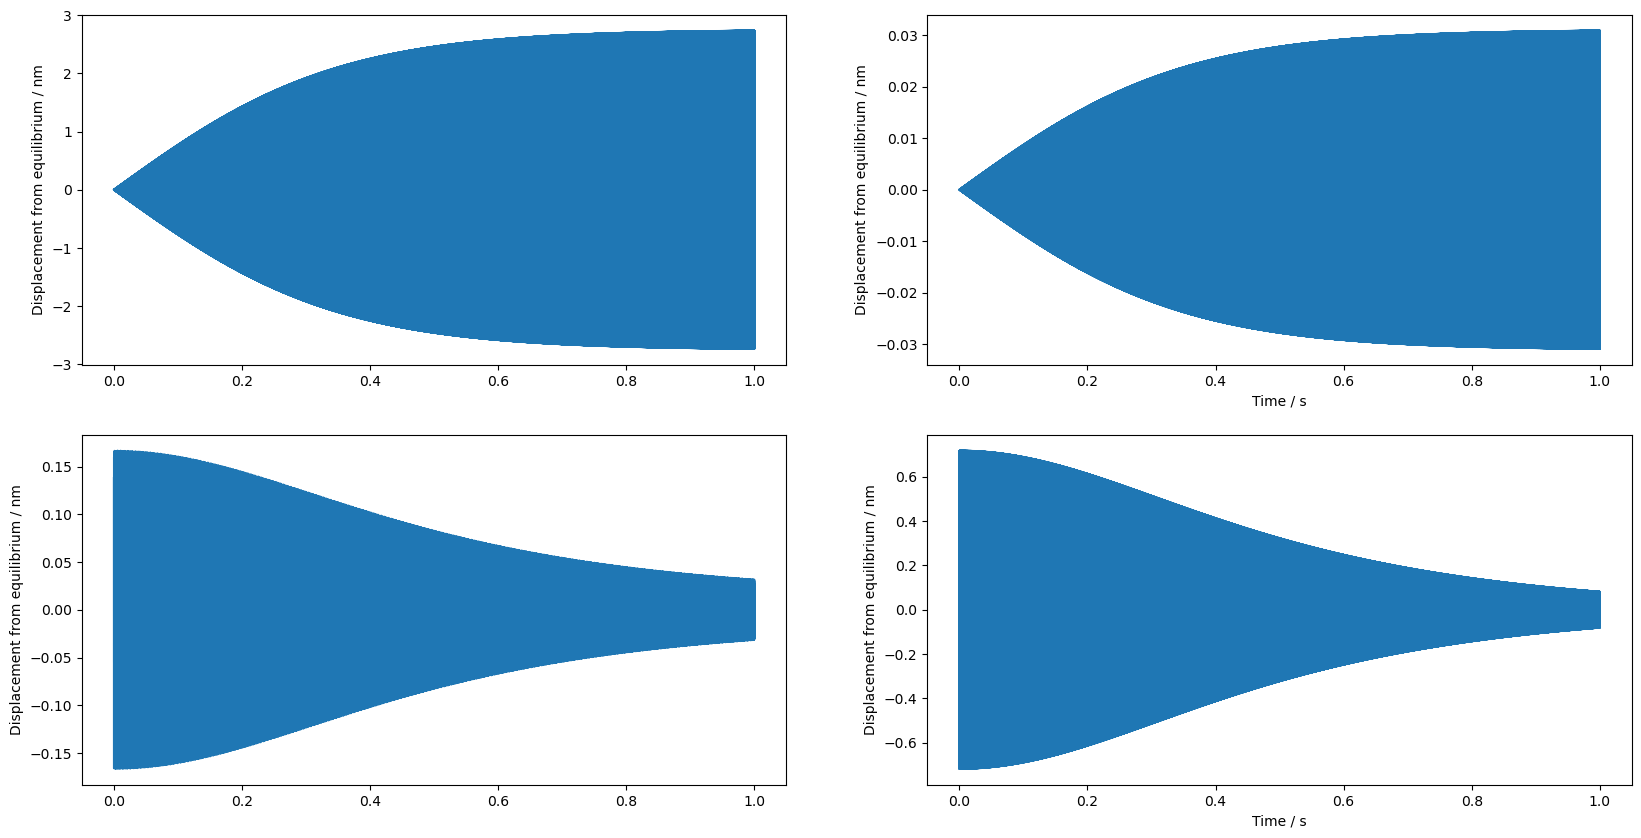

In [11]:
[vec_axi,vec_axo] = [[0.0917244508312306, 0.9957844270321309], [0.995784427032131, -0.09172445083122922]]
fig,ax = plt.subplots(2,2,figsize = (20,10))
ax[0,0].plot(sol_y2.t,(sol_y2.y[0]-z1eq_ax)*1e9)
ax[0,1].plot(sol_y2.t,(sol_y2.y[1]-z2eq_ax)*1e9)
ax[1,0].plot(sol_y2.t,sol_y2.y[2]*1e9)
ax[1,1].plot(sol_y2.t,sol_y2.y[3]*1e9)
ax[0,1].set_xlabel('Time / s')
ax[1,1].set_xlabel('Time / s')
ax[0,0].set_ylabel('Displacement from equilibrium / nm')
ax[0,1].set_ylabel('Displacement from equilibrium / nm')
ax[1,0].set_ylabel('Displacement from equilibrium / nm')
ax[1,1].set_ylabel('Displacement from equilibrium / nm')

In [12]:
axial_vecs = np.zeros((np.size(sol_y2.t),2))
radial_vecs = np.zeros((np.size(sol_y2.t),2))

for j,z1 in enumerate(sol_y2.y[0]):
    axial_vecs[j,0] = (z1-z1eq_ax)*np.sqrt(137)
    axial_vecs[j,1] = (sol_y2.y[1][j]-z2eq_ax)*np.sqrt(9000)

for j,y1 in enumerate(sol_y2.y[2]):
    radial_vecs[j,0] = y1*np.sqrt(137)
    radial_vecs[j,1] = sol_y2.y[3][j]*np.sqrt(9000)
dot_prod_zi = [np.dot(v,vec_axi) for v in axial_vecs]
dot_prod_zo = [np.dot(v,vec_axo) for v in axial_vecs]
dot_prod_ri = [np.dot(v,vecr1) for v in radial_vecs]
dot_prod_ro = [np.dot(v,vecr) for v in radial_vecs]


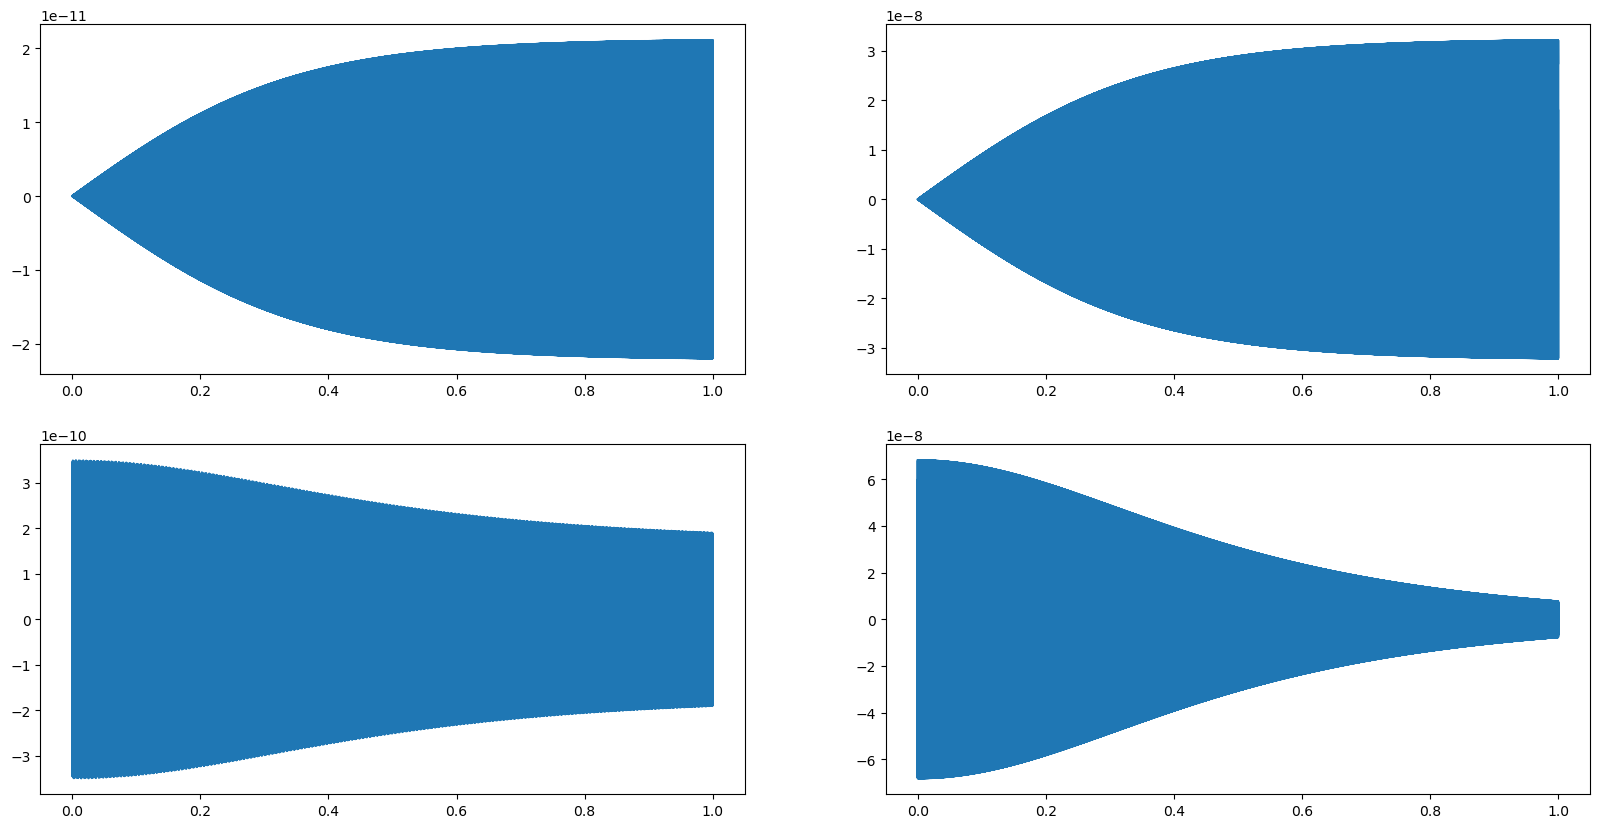

In [13]:
fig,ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(sol_y2.t,dot_prod_zi)
ax[0,1].plot(sol_y2.t,dot_prod_zo)
ax[1,0].plot(sol_y2.t,dot_prod_ri)
ax[1,1].plot(sol_y2.t,dot_prod_ro)
# for axe in ax[0]:
#     axe.set_ylim(-5*1e-10,5*1e-10)
# for axe in ax[1]:
#     axe.set_ylim(-1.3*1e-7,1.3*1e-7)


In [20]:
print(potential_energy(q1,q2,V_end,V_rf,np.array([z1eq,zero*vecr[0]/np.sqrt(m1*1.66*1e27)]),np.array([z2eq,zero*vecr[1]/np.sqrt(m2*1.66*1e27)])))
print(5*hbar*2*np.pi*186.91143732*1e3*6.242*1e18)


3.6953792742835945e-09
3.66529989294078e-09


In [42]:
print(np.size(sol_y2.t))

200001


(186.75, 187.0)

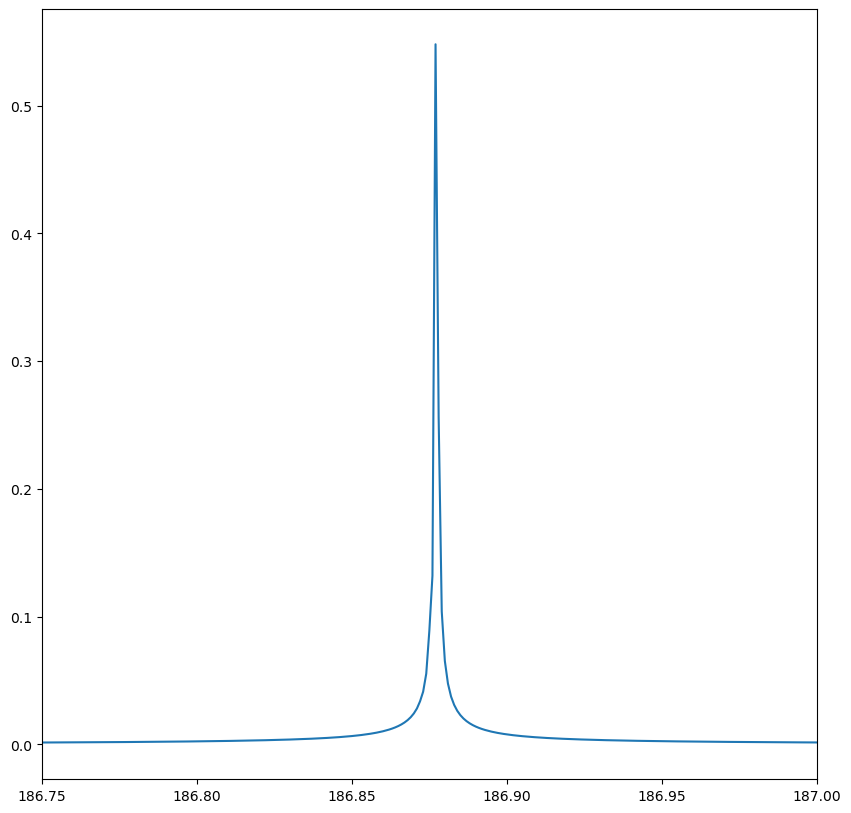

In [52]:
#Try to do FFT
fig,ax = plt.subplots(figsize = (10,10))
yf = fft(dot_prod_ro)
N = np.size(sol_y2.t)
T= 1e-6
xf = fftfreq(N,T)
ax.plot(xf[:N//2]*1e-3,np.abs(yf[:N//2])/(np.max(yf)))
ax.set_xlim(186.75,187)
#plt.axvline(186.9115)

1999
1999
[-8.95276256e-06  1.86684500e+02]
[186.875 186.877]


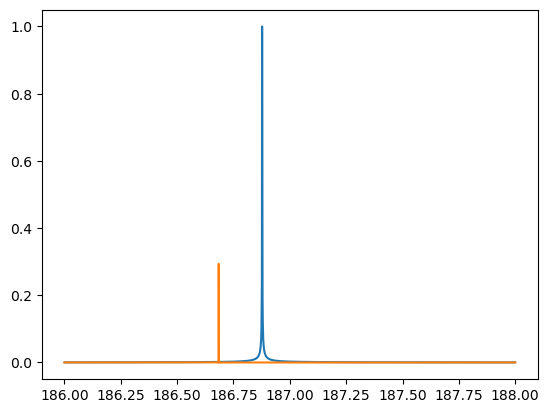

In [54]:
#Fit lorentzian to data.
xdata_temp = xf[:N//2][xf[:N//2]>186*1e3]
xdata = xdata_temp[xdata_temp<188*1e3]
xdata = np.array(xdata)*1e-3
ydata = yf[:N//2][xf[:N//2]>186*1e3]
ydata = ydata[xdata_temp<188*1e3]
print(np.size(xdata))
print(np.size(ydata))
fig,ax = plt.subplots()
ax.plot(xdata,np.abs(ydata)/(np.max(np.abs(ydata))))
def Lorentzian(x,gamma,x0):
    return (gamma/2)*(gamma/2)/((x-x0)**2+(1/2*gamma)**2)
popt_lor,pcov_lor = curve_fit(Lorentzian,xdata,np.abs(ydata),[4,186.88],maxfev = 10000000)

print(popt_lor)
xs = np.linspace(186,188,100000)
ax.plot(xs,Lorentzian(xs,popt_lor[0],popt_lor[1]))
from scipy.signal import find_peaks
peaks,_ = find_peaks(ydata)
print(xdata[peaks])

c:\Users\Emil\anaconda3\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


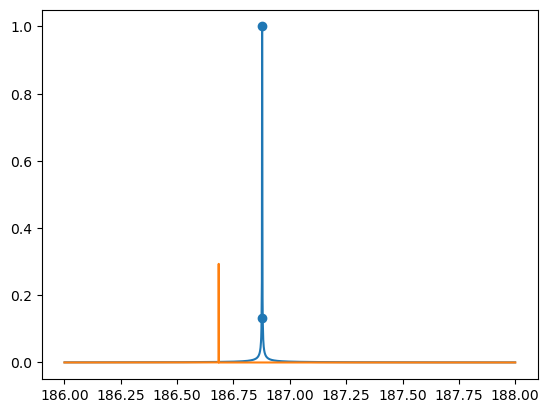

In [55]:
xdata[peaks]
ax.scatter(xdata[peaks],ydata[peaks]/np.max(ydata))
fig


[373752.48722909]
[0.48722909]


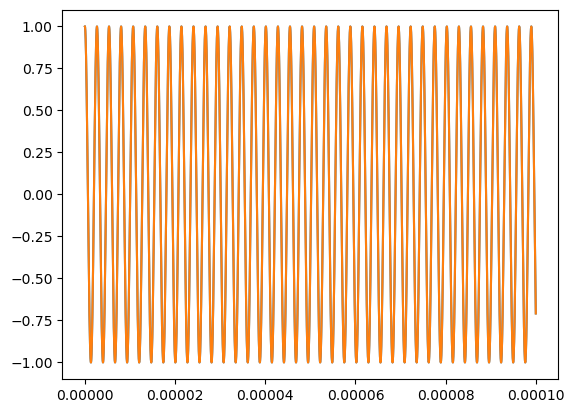

In [29]:
ax_freq_sol = solve_ivp(full_eq_motion,[0,1*1e-4],[z1eq_ax+vec_axo[0]*zero/(np.sqrt(m1*1.66*1e27)),z2eq_ax+vec_axo[1]*zero/(np.sqrt(m2*1.66*1e27)),0,0,0,0,0,0],max_step=5*1e-9)
def cos_fit(x,w):
    return np.cos(w*x)
plt.plot(ax_freq_sol.t,(ax_freq_sol.y[0]-z1eq_ax)/np.max(ax_freq_sol.y[0]-z1eq_ax))

ydat = (ax_freq_sol.y[0]-z1eq_ax)/np.max(ax_freq_sol.y[0]-z1eq_ax)
popt,pcov = curve_fit(cos_fit,ax_freq_sol.t,ydat,p0 = 2*np.pi*370*1e3,maxfev = 1000000)
print(popt/(2*np.pi))
plt.plot(ax_freq_sol.t,cos_fit(ax_freq_sol.t,popt))
print(popt/(2*np.pi)-2*1e3*186.876)

In [3]:
#From some radial frequency try to analytically determine a such that the out of phase axial frequency is exactly half of the radial one.
M = m2/m1
C = ((1+2/(1+1/Q))+Q/M*(1+2/(1+Q))+np.sqrt((1+2/(1+1/Q))**2+(1+2/(1+Q))**2-2*(1+2/(1+1/Q))*(1+2/(1+Q))+16*(1/(M*(1+1/Q)**2))))
a_best = 16*(2*np.pi*186.87994394*1e3)**2/(C*omega_rf**2)
print(a_best)

0.0039679993116511865


In [154]:
@jit
def gss(f, a, b, N_runs= 1000):
    """Golden-section search
    to find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]

    Example:
    >>> f = lambda x: (x-2)**2
    >>> x = gss(f, 1, 5)
    >>> print("%.15f" % x)
    2.000009644875678

    """
    gr = (np.sqrt(5)+1)/2
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    n = 0
    cs = []
    ds = []
    fcs = []
    fds = []
    while n<N_runs:
        n+=1
        cs.append(c)
        ds.append(d)
        fc =f(c)
        fd = f(d)
        fcs.append(fc)
        fds.append(fd)
        if fc > fd:  # f(c) > f(d) to find the maximum, f(c) < f(d) to find min.
            b = d
        else:
            a = c

        # We recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2,cs,ds,fcs,fds

#@jit(parallel = True)
def Objective(parameter):
    V_end_param = 0.0035125*parameter*m1*(z0**2)*(omega_rf**2)/(4*q1*kappa)
    Omega_1zax  = np.sqrt(np.abs(-0.0035125*parameter/2))*omega_rf
    Z1eq_ax = np.cbrt(q1*q2*1/(4*np.pi*epsilon*m1*Omega_1zax**2*(1+1/Q)**2))
    Z2eq_ax = -Z1eq_ax/Q
    #@jit
    def Full_eq_motion(t,Y):
        z1 = Y[0]
        z2 = Y[1]
        y1 = Y[2]
        y2 = Y[3]
        dz1dt = Y[4]
        dz2dt = Y[5]
        dy1dt = Y[6]
        dy2dt = Y[7]
        r1 = np.array([z1,y1])
        r2 = np.array([z2,y2])
        dz1dtdt = voltage_force_axial(q1,V_end_param,z1)/m1+CoulombForce(q1,q2,r1,r2)[0]/m1
        dz2dtdt = voltage_force_axial(q2,V_end_param,z2)/m2+CoulombForce(q1,q2,r2,r1)[0]/m2
        dy1dtdt = radial_force_static(q1,V_end,y1)/m1+CoulombForce(q1,q2,r1,r2)[1]/m1+radial_force_RF(V_rf,q1,y1,t)/m1
        dy2dtdt = radial_force_static(q2,V_end,y2)/m2+CoulombForce(q1,q2,r2,r1)[1]/m2+radial_force_RF(V_rf,q2,y2,t)/m2
        return [dz1dt,dz2dt,dy1dt,dy2dt,dz1dtdt,dz2dtdt,dy1dtdt,dy2dtdt]
    ObjectiveSolution = solve_ivp(Full_eq_motion,[0,0.5],[Z1eq_ax,Z2eq_ax,zero*vecr[0]/np.sqrt(m1*1.66*1e27),zero*vecr[1]/np.sqrt(m2*1.66*1e27),0,0,0,0],max_step=1e-8,t_eval = np.arange(0,0.5,1e-6))
    Axial_vecs = np.zeros((np.size(ObjectiveSolution.t),2))
    Radial_vecs = np.zeros((np.size(ObjectiveSolution.t),2))
    for j,z1 in enumerate(ObjectiveSolution.y[0]):
        Axial_vecs[j,0] = (z1-Z1eq_ax)*np.sqrt(137)
        Axial_vecs[j,1] = (ObjectiveSolution.y[1][j]-Z2eq_ax)*np.sqrt(9000)

    for j,y1 in enumerate(ObjectiveSolution.y[2]):
        Radial_vecs[j,0] = y1*np.sqrt(137)
        Radial_vecs[j,1] = ObjectiveSolution.y[3][j]*np.sqrt(9000)
    #Dot_prod_zi = [np.dot(v,vec_axi) for v in Axial_vecs]
    Dot_prod_zo = [np.dot(v,vec_axo) for v in Axial_vecs]
    #Dot_prod_ri = [np.dot(v,vecr1) for v in Radial_vecs]
    #Dot_prod_ro = [np.dot(v,vecr) for v in Radial_vecs]
    return np.max(np.abs(Dot_prod_zo))



C:\Users\Emil\AppData\Local\Temp\ipykernel_10212\2776479224.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def gss(f, a, b, N_runs= 1000):


In [124]:
testval = Objective(0.99996)
print(testval)

9.91131774079766e+295


In [155]:
Bestval,C_Arr,D_Arr,FC_Arr,FD_Arr = gss(Objective,0.9999,1,N_runs = 15)

C:\Users\Emil\AppData\Local\Temp\ipykernel_10212\2776479224.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gss" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\Emil\AppData\Local\Temp\ipykernel_10212\2776479224.py (1)

File "..\AppData\Local\Temp\ipykernel_10212\2776479224.py", line 1:
<source missing, REPL/exec in use?>

  @jit
c:\Users\Emil\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "gss" was compiled in object mode without forceobj=True.

File "..\AppData\Local\Temp\ipykernel_10212\2776479224.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\Emil\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be re

In [156]:
print(Bestval,C_Arr,D_Arr,FC_Arr,FD_Arr)

0.9999692029230125 [0.999938196601125, 0.999961803398875, 0.99997639320225, 0.9999708203932499, 0.9999673762078751, 0.99997082039325, 0.9999695048315004, 0.9999686917696248, 0.9999695048315003, 0.9999691942694988, 0.9999690023316263, 0.9999691942694989, 0.9999691209557553, 0.9999691942694988, 0.9999691662661406] [0.999961803398875, 0.9999763932022501, 0.999985410196625, 0.9999763932022501, 0.9999708203932499, 0.9999729490168752, 0.9999708203932499, 0.9999695048315003, 0.9999700073313744, 0.9999695048315004, 0.9999691942694988, 0.9999693128936278, 0.9999691942694988, 0.9999692395798843, 0.9999691942694989] [4.860984932623663e-09, 1.583421388929561e-08, 1.6140039198815405e-08, 2.7186538915825964e-08, 2.667407691420918e-08, 2.7186538915825964e-08, 2.8855565257993366e-08, 2.8728321491318216e-08, 2.8855565257993366e-08, 2.8914740615337432e-08, 2.888314384650846e-08, 2.8914740615337432e-08, 2.890662977976982e-08, 2.8914740615337432e-08, 2.8914001090584635e-08] [1.583421388929561e-08, 1.61400

In [149]:

parameter = 0.9999
V_end_param = 0.0035125*parameter*m1*(z0**2)*(omega_rf**2)/(4*q1*kappa)
print(V_end_param)
print(V_end_ax)
Omega_1zax  = np.sqrt(np.abs(-0.0035125*parameter/2))*omega_rf
Z1eq_ax = np.cbrt(q1*q2*1/(4*np.pi*epsilon*m1*Omega_1zax**2*(1+1/Q)**2))
Z2eq_ax = -Z1eq_ax/Q
def Full_eq_motion(t,Y):
    z1 = Y[0]
    z2 = Y[1]
    y1 = Y[2]
    y2 = Y[3]
    dz1dt = Y[4]
    dz2dt = Y[5]
    dy1dt = Y[6]
    dy2dt = Y[7]
    r1 = np.array([z1,y1])
    r2 = np.array([z2,y2])
    dz1dtdt = voltage_force_axial(q1,V_end_param,z1)/m1+CoulombForce(q1,q2,r1,r2)[0]/m1
    dz2dtdt = voltage_force_axial(q2,V_end_param,z2)/m2+CoulombForce(q1,q2,r2,r1)[0]/m2
    dy1dtdt = radial_force_static(q1,V_end,y1)/m1+CoulombForce(q1,q2,r1,r2)[1]/m1+radial_force_RF(V_rf,q1,y1,t)/m1
    dy2dtdt = radial_force_static(q2,V_end,y2)/m2+CoulombForce(q1,q2,r2,r1)[1]/m2+radial_force_RF(V_rf,q2,y2,t)/m2
    return [dz1dt,dz2dt,dy1dt,dy2dt,dz1dtdt,dz2dtdt,dy1dtdt,dy2dtdt]
ObjectiveSolution = solve_ivp(Full_eq_motion,[0,0.5],[Z1eq_ax,Z2eq_ax,zero*vecr[0]/np.sqrt(m1*1.66*1e27),zero*vecr[1]/np.sqrt(m2*1.66*1e27),0,0,0,0],max_step=1e-8,t_eval = np.arange(0,0.5,1e-6))


-21.706988796684744
21.708291346267504


[0.00000000e+000 9.21892874e+001 3.62136259e+002 1.42193116e+003
 5.59047316e+003 2.19818624e+004 8.64337851e+004 3.39862137e+005
 1.33635563e+006 5.25461999e+006 2.06614396e+007 8.12418575e+007
 3.19447218e+008 1.25608311e+009 4.93898425e+009 1.94203435e+010
 7.63618026e+010 3.00258588e+011 1.18063241e+012 4.64230819e+012
 1.82537977e+013 7.17748840e+013 2.82222585e+014 1.10971391e+015
 4.36345293e+015 1.71573243e+016 6.74634935e+016 2.65269972e+017
 1.04305536e+018 4.10134802e+018 1.61267142e+019 6.34110806e+019
 2.49335674e+020 9.80400864e+020 3.85498729e+021 1.51580109e+022
 5.96020890e+022 2.34358520e+023 9.21509915e+023 3.62342501e+024
 1.42474960e+025 5.60218968e+025 2.20281018e+026 8.66156442e+026
 3.40577227e+027 1.33916741e+028 5.26567604e+028 2.07049126e+029
 8.14127955e+029 3.20119355e+030 1.25872599e+031 4.94937618e+031
 1.94612051e+032 7.65224727e+032 3.00890351e+033 1.18311654e+034
 4.65207590e+034 1.82922049e+035 7.19259029e+035 2.82816399e+036
 1.11204882e+037 4.372633

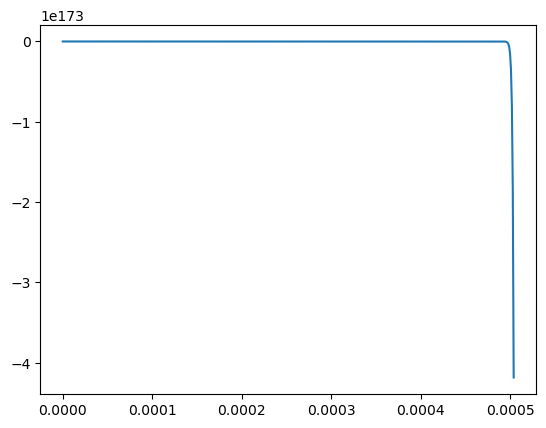

In [147]:
fig,ax = plt.subplots()
ax.plot(ObjectiveSolution.t,ObjectiveSolution.y[1])
print(ObjectiveSolution.y[4])